# Aim

Test out LQG control on some random system I throw together, so I'm familiar with the syntax and effectiveness.

In [1]:
using ControlSystems
import ControlSystems: dare
using NPZ
using LinearAlgebra
using Revise
using ttsysid
import ttsysid: KFilter

eye(n) = Matrix{Float64}(I,n,n)
openloops = npzread("../data/sims/atm_openloops.npy")[:,1];

┌ Info: Precompiling ttsysid [8fd88530-110a-5f69-a7ee-45470816746c]
└ @ Base loading.jl:1317


In [8]:
ar_len = 2
@time kf = make_kfilter_ar(ar_len, openloops[1:100])
sys_ar = ss(kf.A, kf.B, kf.C, 0.0, 0.001)

Took 11 iterations to reach steady-state covariance.
  0.000241 seconds (254 allocations: 98.609 KiB)


StateSpace{Discrete{Float64}, Float64}
A = 
 1.6602288107201026  -0.6861536003228691
 1.0                  0.0
B = 
 1.0
 0.0
C = 
 1.0  0.0
D = 
 0.0

Sample Time: 0.001 (seconds)
Discrete-time state-space model

In [3]:
dare(kf::KFilter) = dare(kf.A', kf.C', kf.Q, kf.R)

dare (generic function with 2 methods)

In [7]:
@time P = dare(kf) 

  0.001932 seconds (80 allocations: 9.531 KiB)


2×2 Matrix{Float64}:
 0.0155127   0.00429585
 0.00429585  0.00292192

In [5]:
P * kf.C' * inv(kf.C * P * kf.C' + kf.R)

2×1 Matrix{Float64}:
 0.811643741203085
 0.22476396403958643

In [6]:
kf.K

2×1 Matrix{Float64}:
 0.811643741341493
 0.22476396402934087

In [10]:
G = LQG(sys_ar, eye(ar_len), eye(1), kf.Q, kf.R, qQ=0.001, qR=0)

LQG(StateSpace{Continuous, Float64}
A = 
 1.6602288107201026  -0.6861536003228691
 1.0                  0.0
B = 
 1.0
 0.0
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model, [1.0 0.0; 0.0 1.0], [1.0], [0.008381314805331297 0.0; 0.0 0.0], [0.0036], 0.001, 0, StateSpace{Continuous, Float64}
A = 
 -6.108418484453166   -1.2127682232133348
  1.0000000000000078   0.0
B = 
  3.9151129996366922
 -7.70261890434369e-15
C = 
 3.853534295536576  0.5266146228904657
D = 
 0.0

Continuous-time state-space model, [3.853534295536576 0.5266146228904657], [3.9151129996366922; -7.70261890434369e-15], [1.0 0.0], false)

In [11]:
G.cl

StateSpace{Continuous, Float64}
A = 
 -2.1933054848164732  -1.2127682232133348   3.853534295536576    0.5266146228904657
  1.0                  0.0                  0.0                  0.0
  0.0                  0.0                 -2.2548841889165896  -0.6861536003228691
  0.0                  0.0                  1.0000000000000078   0.0
B = 
 1.9755539528258268e16
 0.0
 0.0
 0.0
C = 
 1.0  0.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

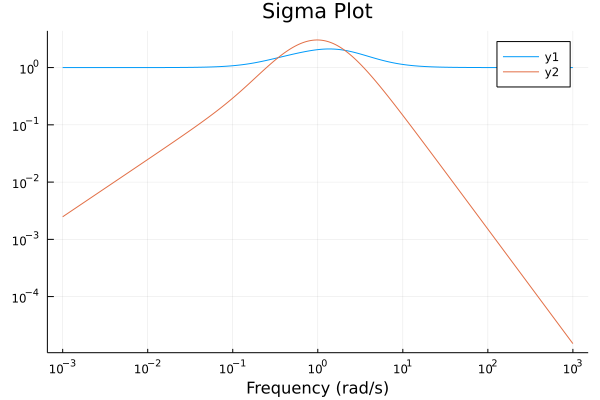

In [14]:
Gcl = G.cl
T = G.T
S = G.S
sigmaplot([S,T], exp10.(range(-3, stop=3, length=1000)))

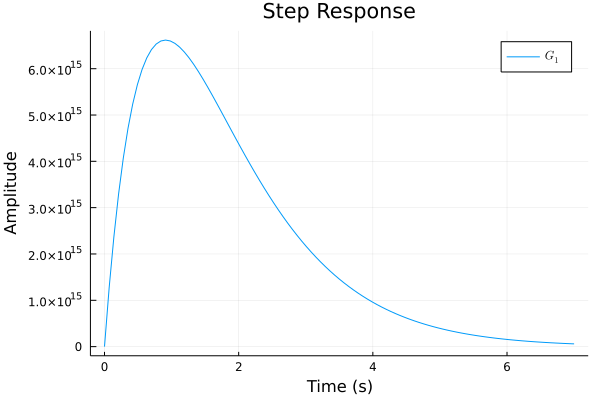

In [15]:
stepplot(Gcl)

In [95]:
dampreport(Gcl)

|     Pole      |   Damping     |   Frequency   | Time Constant |
|               |    Ratio      |   (rad/sec)   |     (sec)     |
+---------------+---------------+---------------+---------------+
|  -3.626e-01   |  1.000e+00    |  3.626e-01    |  2.758e+00    |
|  +0.000e+00 im|               |               |               |
|  -1.097e+00   |  9.958e-01    |  1.101e+00    |  9.119e-01    |
|  +1.006e-01 im|               |               |               |
|  -1.097e+00   |  9.958e-01    |  1.101e+00    |  9.119e-01    |
|  -1.006e-01 im|               |               |               |
|  -1.892e+00   |  1.000e+00    |  1.892e+00    |  5.285e-01    |
|  +0.000e+00 im|               |               |               |


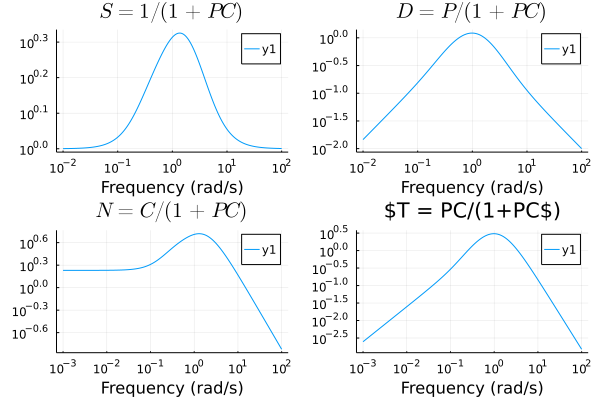

In [12]:
gangoffourplot(G)